In [1]:
%load_ext autoreload
%autoreload 2

# Verify conditional circuit generation

We have previously trained a neural network known as a conditional variational autoencoder on genetic circuits. The conditioning variable was made to be one of the characteristics of the genetic circuit's dynamics, for example the sensitivity of the circuit to a signal. While the distributions for each class of conditional variables differ in the AI-generated circuits, the verification of their ground-truth label is still necessary to assess the validity of the conditionality.

## Imports

In [ ]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation

from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 02_cvae_verify.ipynb --output=02_cvae_verify_2.ipynb --ExecutePreprocessor.timeout=-1



[cuda(id=0), cuda(id=1)]

In [3]:
from evoscaper.utils.dataset import embellish_data
from evoscaper.model.evaluation import calc_prompt_adherence
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.scripts.verify import verify
from evoscaper.utils.math import arrayise
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import vis_sampled_histplot, create_network_inset


# Use verify function

In [4]:
# hpos = pd.Series(load_json_as_dict('data/01_cvae/2025_01_21__15_09_53/hpos_all.json'))
 
# fn_saves = os.path.join('weight_saves', '01_cvae',
#                         # '2024_12_19__16_10_53_saves_hs16_ls32_nlayers2_adam')
#                         # 'saves_2025_01_14__16_43_17_prec_sens')
#                         # 'saves_2025_01_14__17_44_21_sens')
#                         # 'saves_2025_01_17__16_01_57_sens_no_cat')
#                         'saves_2025_01_21__22_40_13_no_cat_sens_prec')
# fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__15_33_42_adapt')
# fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__21_26_05_prec_sens') 


dir_src = os.path.join('data', '01_cvae', '2025_02_23__18_41_24')
hpos = pd.Series(load_json_as_dict(os.path.join(dir_src, 'hpos_all.json')))
fn_saves = os.path.join(dir_src, 'saves_2025_02_23__18_41_24_ds0211_spbool_KL2e4')
saves_loaded = load_json_as_dict(fn_saves)
top_write_dir = os.path.join('data', '02_cvae_verify', make_datetime_str())
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

if not os.path.exists(top_write_dir):
    os.makedirs(top_write_dir)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
if 'base_configs_ensemble' in config_bio:
    val_config = config_bio['base_configs_ensemble']['generate_species_templates']
    val_config.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])
else:
    val_config = config_bio

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Run

In [ ]:
hpos['eval_n_to_sample'] = 5000
hpos['eval_n_sample_categories'] = 5 # if ('Log sensitivity > 1' in config_dataset.objective_col) or ('Log precision > 0' in config_dataset.objective_col) else 2
val_config['simulation']['threshold_steady_states'] = 0.01
val_config['simulation']['t1'] = 1000
val_config['simulation']['tmax'] = 6000
n_to_sample_per_cat = int(int(hpos['eval_n_to_sample']) / (
    int(hpos['eval_n_sample_categories']) ** len(config_dataset.objective_col)))
input_species = data[data['sample_name'].notna()]['sample_name'].unique()

print('Going to sample', n_to_sample_per_cat,
      'per category for a total of', int(hpos['eval_n_to_sample']), 'samples')

Going to sample 200 per category for a total of 5000 samples


In [6]:
data['response_time_wrt_species-6'] = np.where(data['response_time_wrt_species-6'] < np.inf, data['response_time_wrt_species-6'], np.nan)

filt = (data['response_time_wrt_species-6'] < (0.8 * np.nanmax(data['response_time_wrt_species-6']))) & (data['sample_name'] == 'RNA_2')
# sns.histplot(data, x='response_time_wrt_species-6', bins=50)
data[filt].iloc[(np.argmax(np.log10(data[filt]['sensitivity_wrt_species-6'])))]['response_time_wrt_species-6'], np.log10(data[filt]['sensitivity_wrt_species-6']).max(), len(data[filt]), len(data[data['sample_name'] == 'RNA_2'])

(np.float64(163.2653045654), np.float64(2.4822644931036644), 81961, 859930)

In [7]:
# config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal']['simulation']['threshold_steady_states'] = 0.01
# config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal']['simulation']['t1'] = 1000

In [ ]:
use_run = False

if use_run:
    (
        analytics, ys, ts, y0m, y00s, ts0, fake_circuits, reverse_rates, model_brn, qreactions, ordered_species, input_species, z, sampled_cond
    ) = verify(params=params,
               rng=rng,
               decoder=decoder,
               df=df,
               cond=np.array([-0.1, 1.1]),
               config_bio=val_config,
               config_norm_y=config_norm_y,
               config_dataset=config_dataset,
               config_model=config_model,
               x_datanormaliser=x_datanormaliser,
               x_methods_preprocessing=x_methods_preprocessing,
               y_datanormaliser=y_datanormaliser,
               output_species=config_dataset.output_species,
               signal_species=config_dataset.signal_species,
               input_species=input_species,
               n_to_sample=n_to_sample_per_cat,
               visualise=True,
               top_write_dir=top_write_dir,
               return_relevant=True,
               impose_final_range=(df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].min().min(),
                                   df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].max().max()))
else:
    analytics = load_json_as_dict(os.path.join('data/02_cvae_verify/2025_02_24__18_16_57', 'analytics.json'))
    ts = np.load(os.path.join('data/02_cvae_verify/2025_02_24__18_16_57', 'ts.npy'))
    ys = np.load(os.path.join('data/02_cvae_verify/2025_02_24__18_16_57', 'ys.npy'))
    fake_circuits = np.load(os.path.join('data/02_cvae_verify/2025_02_24__18_16_57', 'fake_circuits.npy'))
    y0m = np.load(os.path.join('data/02_cvae_verify/2025_02_24__18_16_57', 'y0m.npy'))
    sampled_cond = np.load(os.path.join('data/02_cvae_verify/2025_02_24__18_16_57', 'sampled_cond.npy'))
    ts0 = np.array([])
    y00s = np.array([])

In [ ]:
for k in analytics.keys():
    analytics[k] = np.array(analytics[k])
analytics['adaptation'] = calculate_adaptation(
    analytics['sensitivity_wrt_species-6'], analytics['precision_wrt_species-6'])

ts.shape, ys.shape, y0m.shape, y00s.shape, ts0.shape

((50,), (5000, 50, 9), (5000, 1, 9), (0,), (0,))

In [ ]:
idx_output = -1
n_show = int(1e3)

if len(y00s):
    # plt.plot(np.repeat(ts[None, :], repeats=n_show, axis=0).T, ys[:n_show, :, -3].T, alpha=0.05, color='b')
    # plt.plot(np.repeat(ts[None, :], repeats=n_show, axis=0).T, ys[:n_show, :, -2].T, alpha=0.05, color='g')
    # plt.plot(np.repeat(ts[None, :], repeats=n_show, axis=0).T, ys[:n_show, :, -1].T, alpha=0.05, color='r')
    plt.plot(np.repeat(np.concatenate([ts0, ts+ts0.max()])[None, :], repeats=n_show, axis=0).T,
            np.concatenate([y00s[:n_show, :, -3].T, ys[:n_show, :, -3].T], axis=0), color='b', alpha=0.05)
    plt.plot(np.repeat(np.concatenate([ts0, ts+ts0.max()])[None, :], repeats=n_show, axis=0).T,
            np.concatenate([y00s[:n_show, :, -2].T, ys[:n_show, :, -2].T], axis=0), color='y', alpha=0.05)
    plt.plot(np.repeat(np.concatenate([ts0, ts+ts0.max()])[None, :], repeats=n_show, axis=0).T,
            np.concatenate([y00s[:n_show, :, -1].T, ys[:n_show, :, -1].T], axis=0), color='r', alpha=0.05)
    plt.xlabel('time')

    plt.figure()
    plt.plot(np.repeat(ts0[None, :], repeats=n_show, axis=0).T, y00s[:n_show, :, idx_output].T, alpha=0.05, color='b')
    plt.xlabel('time')

In [11]:
# print(data_writer.top_write_dir)
# data_writer.output(data=analytics, out_type='json', out_name='analytics')
# data_writer.output(data=ys, out_type='npy', out_name='ys')
# data_writer.output(data=ts, out_type='npy', out_name='ts')
# data_writer.output(data=y0m, out_type='npy', out_name='y0m')
# data_writer.output(data=fake_circuits, out_type='npy', out_name='fake_circuits')

In [12]:
idx_output = -1
idx_signal = -3
# idxs_viable = np.where((analytics['response_time_wrt_species-6'][:, idx_output] < 0.8*analytics['response_time_wrt_species-6'].max()) & (
#     analytics['overshoot'][:, idx_output] > 1e-3) & (
#         analytics['initial_steady_states'][:, idx_output] > 1))[0]
# df_max = pd.DataFrame(analytics['sensitivity_wrt_species-6'][:, idx_output], columns=['sensitivity'])
# df_max['overshoot'] = analytics['sensitivity_wrt_species-6'][:, idx_output]
# idx_max = df_max.iloc[idxs_viable]['overshoot'].idxmax()
idx_max = np.nanargmax(analytics['adaptation'][:, idx_output])
# idx_max = np.nanargmax(analytics['sensitivity_wrt_species-6'][:, idx_output])
# idx_max = np.argmax(analytics['overshoot'][:, idx_output])


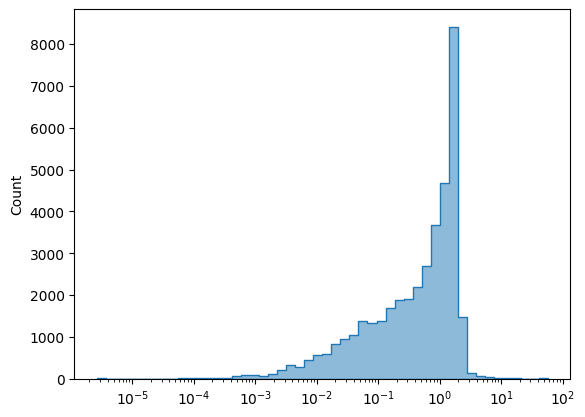

In [13]:
sns.histplot(analytics['sensitivity_wrt_species-6'][np.where(analytics['response_time_wrt_species-6'] < 1e2)[0]][:, idx_output], bins=50, element='step', log_scale=[True, False], alpha=0.5)
pd.DataFrame(analytics['sensitivity_wrt_species-6'][:, idx_output]).describe(), np.median(analytics['sensitivity_wrt_species-6'][:, idx_output])
d = pd.DataFrame(analytics['sensitivity_wrt_species-6'][:, idx_output])
idxs_med = d[d[0].between(*np.median(analytics['sensitivity_wrt_species-6'][:, idx_output]) + np.array([-0.01, 0.01]))].index.to_numpy()
fake_circuits_f = fake_circuits.reshape(-1, fake_circuits.shape[-1])
# fake_circuits_f[idxs_med]

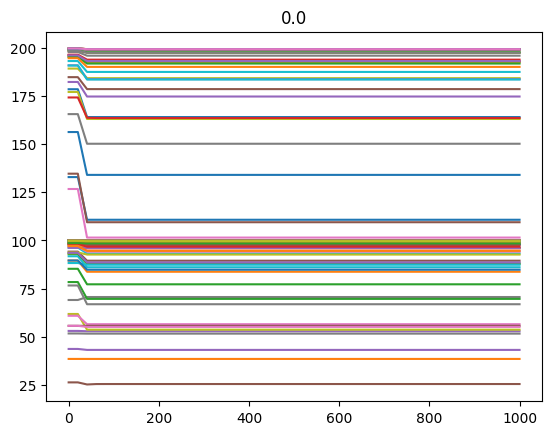

In [14]:
for i in idxs_med:

    plt.plot(ts, ys[i, :, -3:])
    plt.title(analytics['overshoot'][i, idx_output]/ analytics['initial_steady_states'][i, idx_output])
# plt.plot(np.repeat(ts[:, None], repeats=len(idxs_med), axis=-1), ys[idxs_med, :, idx_output].T, color='b')

In [15]:
np.nanmax(analytics['sensitivity_wrt_species-6'][:, idx_output])

np.float64(57.60880661010742)

In [16]:
analytics['initial_steady_states'][idx_max, -3]

np.float64(199.08570861816406)

(array([ -0.10668647,   0.        ,  -8.016191  ,   0.        ,
          0.        , -19.846504  ], dtype=float32),
 np.float64(57.60880661010742))

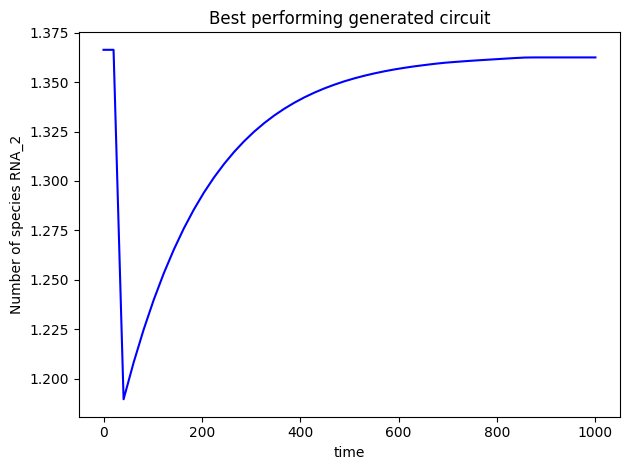

In [17]:
idx_signal = -3
plt.plot(ts, ys[idx_max, :, idx_output].T, color='b')
plt.xlabel('time')
plt.ylabel(f'Number of species {input_species[idx_output]}')
plt.title('Best performing generated circuit')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'best_performing_circuit.png'))
fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idx_max], analytics['sensitivity_wrt_species-6'][idx_max, idx_output]


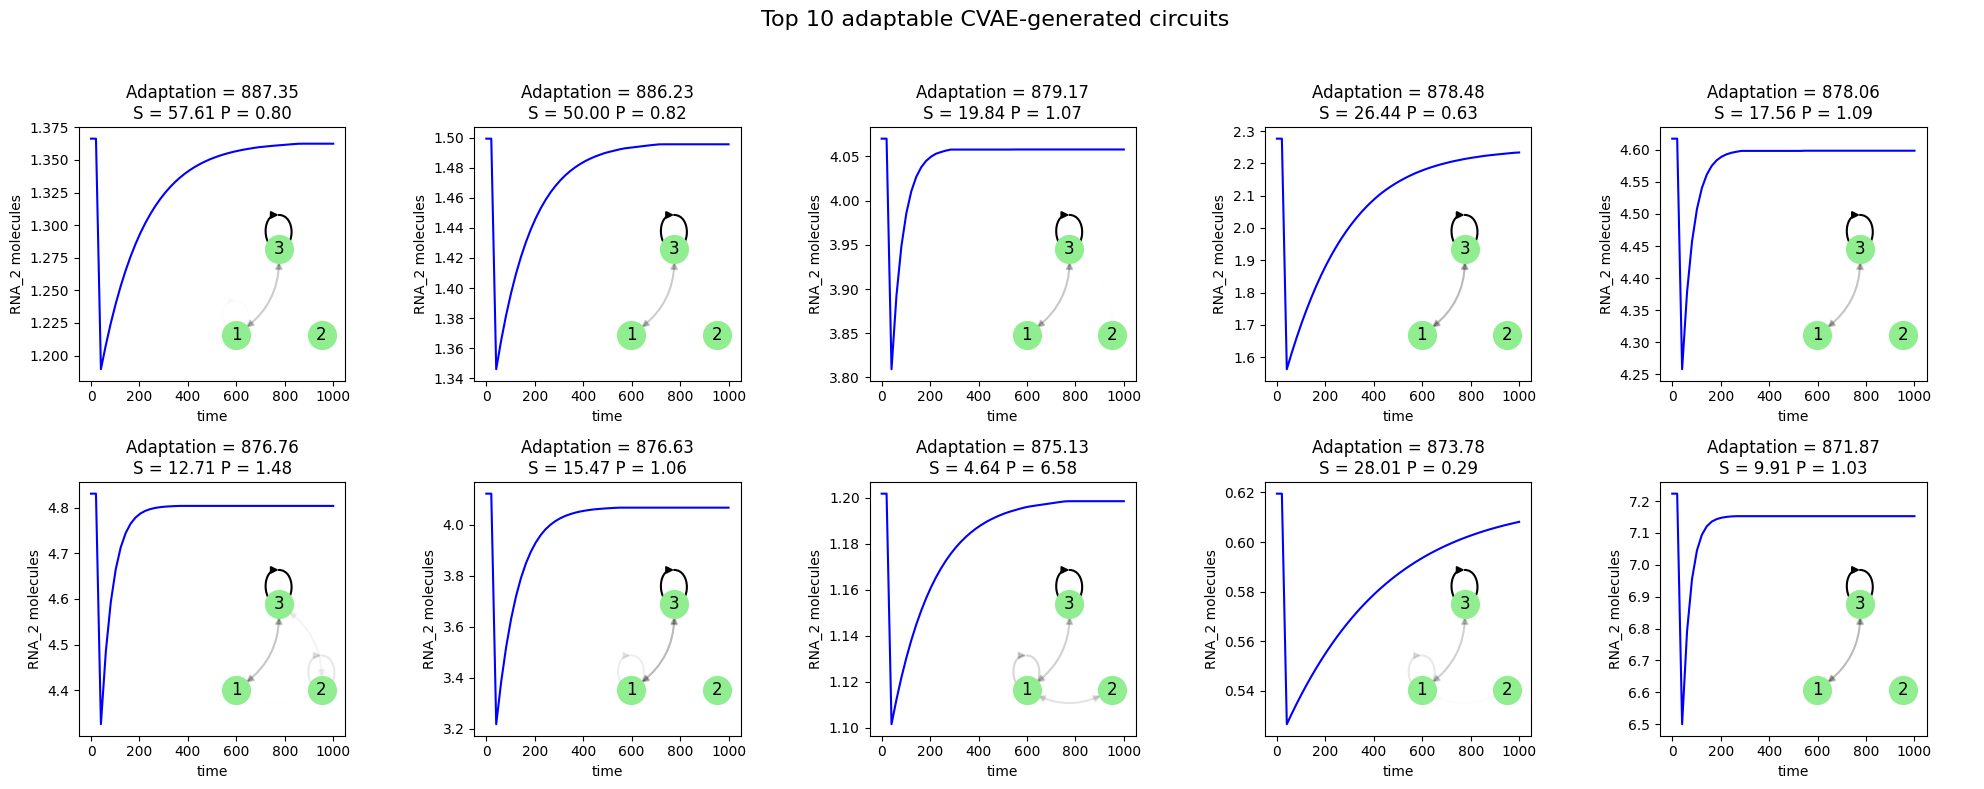

In [18]:
n_top = 10
# a = np.array(analytics['adaptation'])
# a = np.where(np.isfinite(analytics['adaptation']) & (np.array(analytics['response_time_wrt_species-6']) < 750), analytics['adaptation'], np.nan)
# a = np.where(np.isfinite(analytics['adaptation']) & (np.array(analytics['initial_steady_states']) > 10), analytics['adaptation'], 0)
a = np.where(np.isfinite(analytics['adaptation']) & (
    analytics['overshoot'] / analytics['initial_steady_states'] > 0.05) & (
        analytics['response_time_wrt_species-6'] < (0.9 * analytics['response_time_wrt_species-6'].max())
        ) & (analytics['initial_steady_states'] > 0), analytics['adaptation'], 0)
# idxs_top_adapt = np.argsort(a[:, idx_output])[:n_top]
idxs_top_adapt = np.argsort(a[:, idx_output])[-n_top:][::-1]
nrows = 2
ncols = int(np.ceil(n_top / nrows))


def make_nx_weights(energies, n_nodes):
    energies_mod = np.interp(
        energies, (energies.min(), energies.max()), (1, 0))
    keys = [tuple(sorted(ii)) for ii in zip(*[(i + 1).tolist()
                                              for i in np.triu_indices(n_nodes)])]
    weights = dict(zip(keys, energies_mod.round(2).tolist()))
    # keys2 = [tuple(np.array(ii)[::-1].tolist()) for ii in zip(*[(i + 1).tolist() for i in np.triu_indices(n_nodes)])]
    # weights2 = dict(zip(keys2, energies_mod.round(2).tolist()))
    # weights.update(weights2)
    return weights


fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(ncols * 4, nrows * 4))
t_plotmax = int(30000*0.8)
for i, idx in enumerate(idxs_top_adapt):
    ax = axs[i // ncols, i % ncols]
    ax.plot(ts, ys[idx, :, idx_output].T, color='b')
    # ax.plot(ts, ys[idx, :, idx_signal].T, color='r')
    # ax.set_ylim([0, 410])
    w = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idx]
    create_network_inset(fig, ax, width=0.9, height=0.9, edge_weights=make_nx_weights(
        w, n_nodes=3), node_color='lightgreen')
    ax.set_title(f'Adaptation = {a[idx, idx_output]:.2f}\nS = {analytics["sensitivity_wrt_species-6"][idx, idx_output]:.2f} P = {analytics["precision_wrt_species-6"][idx, idx_output]:.2f}')
    ax.set_xlabel('time')
    ax.set_ylabel(f'{input_species[idx_output]} molecules')

plt.suptitle(f'Top {n_top} adaptable CVAE-generated circuits', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir,
            'best_performing_circuits_networks.png'))

# w, fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idxs_top_adapt] #, analytics['sensitivity_wrt_species-6'][idx_max, idx_output]

In [ ]:
idx_signal = -3
idx_output = -1 
if len(y00s):
    plt.plot(np.concatenate([ts0, ts+ts0.max()]),
            np.concatenate([y00s[idx_max, :, -3:].T, ys[idx_max, :, -3:].T], axis=-1).T)
    plt.xlabel('time')
    plt.ylabel(f'Amount of species {input_species[idx_output]}')
    plt.title('Best performing generated circuit')

    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'best_performing_circuit_full.png'))
    fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idx_max], analytics['sensitivity_wrt_species-6'][idx_max, idx_output], analytics['adaptation'][idx_max, idx_output], analytics['overshoot'][idx_max, idx_output], analytics['response_time_wrt_species-6'][idx_max, idx_output]

# Visualise

In [100]:
category_array = np.concatenate([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(
    sampled_cond[..., i], col=c)[..., None] for i, c in enumerate(config_dataset.objective_col)], axis=-1).reshape(np.prod(sampled_cond.shape[:-1]), -1)
# category_array = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sampled_cond, config_dataset.objective_col[0]).reshape(np.prod(sampled_cond.shape[:-1]), -1)

In [101]:
category_array.shape

(5000, 2)

In [102]:
output_species = ['RNA_1', 'RNA_2']
all_species = [str(i) for i in range(np.array(analytics['sensitivity_wrt_species-6']).shape[-1] - len(input_species))] + list(input_species)

if 'Log sensitivity' not in analytics:
    analytics['Log sensitivity'] = np.log10(analytics['sensitivity_wrt_species-6'])
    analytics['Log precision'] = np.log10(analytics['precision_wrt_species-6'])


s_obj = set(['sensitivity_wrt_species-6', 'Log sensitivity', 'Log sensitivity > 0']).intersection(set(config_dataset.objective_col)).pop()
idx_sens = config_dataset.objective_col.index(s_obj)
vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], all_species, output_species, category_array[:, idx_sens, None], 
                     title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='layer', 
                     show=False, save_path=os.path.join(top_write_dir, 'hist_sens_layer.png'))

vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], all_species, output_species, category_array[:, idx_sens, None], 
                     title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='fill', 
                     show=False, save_path=os.path.join(top_write_dir, 'hist_sens_fill.png'))

vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], all_species, output_species, category_array[:, idx_sens, None], 
                     title=f'Sensitivity of generated circuits', x_label=f'Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='layer', 
                     show=False, save_path=os.path.join(top_write_dir, 'hist_sens_kde.png'),
                     f=sns.kdeplot, log_scale=[True, False], fill=False)

In [103]:
vis_sampled_histplot(analytics['adaptation'], all_species, output_species, category_array,
                     title=f'Adaptation of generated circuits', x_label=f'Log10 Adaptation to signal {config_dataset.signal_species[0]}', multiple='layer', 
                     show=False, save_path=os.path.join(top_write_dir, 'hist_adapt_layer.png'))

vis_sampled_histplot(analytics['adaptation'], all_species, output_species, category_array,
                     title=f'Adaptation of generated circuits', x_label=f'Log10 Adaptation to signal {config_dataset.signal_species[0]}', multiple='fill', 
                     show=False, save_path=os.path.join(top_write_dir, 'hist_adapt_fill.png'))

vis_sampled_histplot(analytics['adaptation'], all_species, output_species, category_array,
                     title=f'Sensitivity of generated circuits', x_label=f'Log10 Adaptation to signal {config_dataset.signal_species[0]}', multiple='layer', 
                     show=False, save_path=os.path.join(top_write_dir, 'hist_adapt_kde.png'),
                     f=sns.kdeplot, log_scale=[True, False], fill=False)

/workdir/src/evoscaper/utils/dataset.py:89: RuntimeWarning: divide by zero encountered in log10
  data[k] != 0, np.log10(data[k]), zero_log_replacement)
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropr

category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


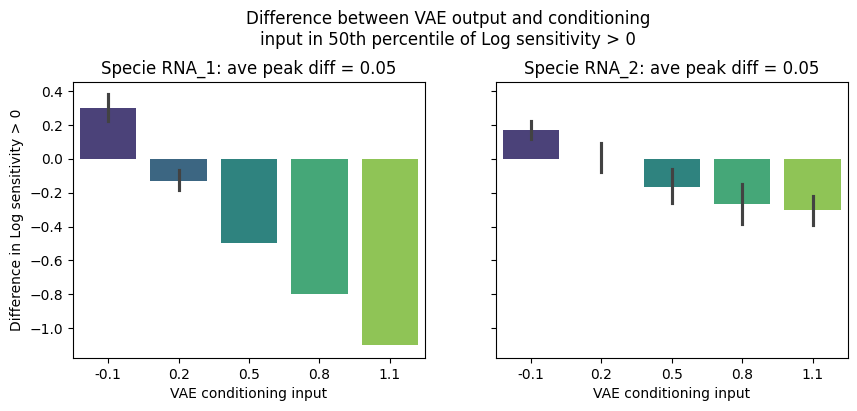

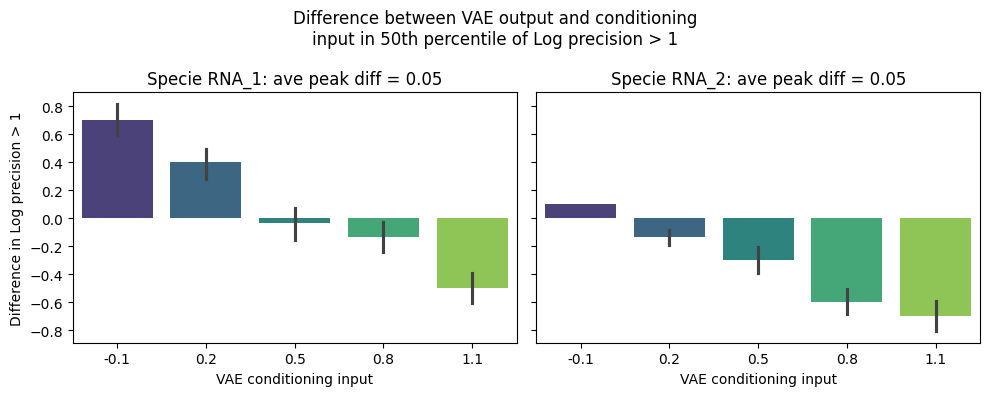

In [104]:
def plot_diffs(diffs_conditional_real_sens, objective_col, sampled_conds, ax, palette='viridis', f_plot=sns.barplot):
    f_plot(pd.DataFrame(diffs_conditional_real_sens.T, columns=sampled_conds.round(3).flatten(), #[
        # str(ii)[:5] for ii in sampled_conds.flatten()]
        ), 
        palette=palette, ax=ax)
    ax.set_xlabel('VAE conditioning input')
    ax.set_ylabel(f'Difference in {objective_col}')


# for k in ['sensitivity_wrt_species-6', 'precision_wrt_species-6', 'adaptation']:
#     analytics[k] = np.where(np.isnan(
#         analytics[k]), 0, analytics[k])
#     analytics[f'Log {k.split("_")[0]}'] = np.log10(analytics[k])
analytics = embellish_data(analytics)
n_categories = fake_circuits.shape[0]

sampled_conds = sampled_cond.mean(axis=1)
for ii, k in enumerate(config_dataset.objective_col):
    # sampled_conds = np.array(
    #     sorted(y_datanormaliser.metadata[k]['category_map'].values()))

    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    fig.subplots_adjust(hspace=0.3, top=0.8)
    for i, output_specie in enumerate(output_species):
        output_idx = all_species.index(output_specie)
        diffs_conditional_real_sens = jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
            analytics[k][:, output_idx].reshape(n_categories, int(hpos['eval_n_to_sample']) // n_categories)) - sampled_conds[:, ii, None]

        plt.axes(axs[i])
        plot_diffs(diffs_conditional_real_sens, k, sampled_conds[..., ii], axs[i])
        plt.title(f'Specie {output_specie}: ave peak diff = {np.nanmean(diffs_conditional_real_sens[:-1, 1] - diffs_conditional_real_sens[1:, 1]):.2f}')
        # print('Diffs:', diffs_conditional_real_sens[:, 1], np.sum(
        #     np.abs(diffs_conditional_real_sens[:, 1])))

    plt.suptitle(
        f'Difference between VAE output and conditioning\ninput in 50th percentile of {k}')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'diffs_sens_barplot.png'), dpi=300, transparent=True)
    

category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


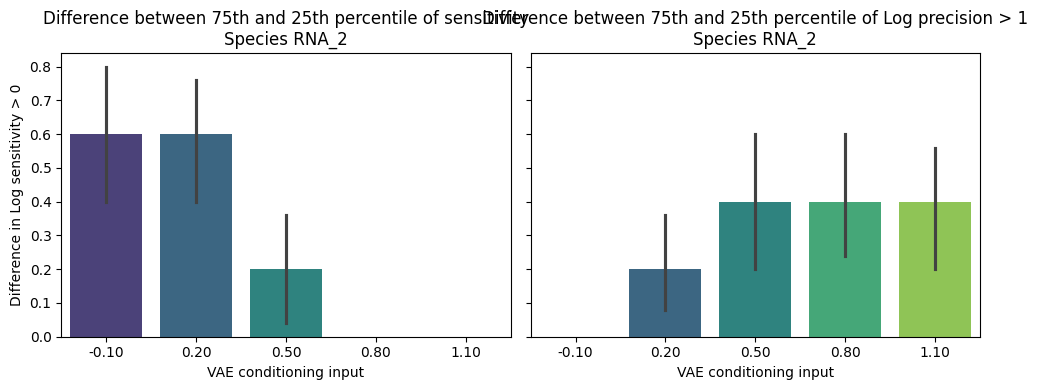

In [105]:
fig, axs = plt.subplots(1, len(config_dataset.objective_col), sharey=True, figsize=(10, 4))
for i, k in enumerate(config_dataset.objective_col):
    sns.barplot(pd.DataFrame((diffs_conditional_real_sens[..., -1] - diffs_conditional_real_sens[..., 0])[None, :], columns=[
                f'{ii:.2f}' for ii in sampled_conds[..., i].flatten()]), palette='viridis', ax=axs[i])
    txt = 'sensitivity' if 'sensitivity' in k else ('adaptation' if 'adaptation' in k else k)
    axs[i].set_title(f'Difference between 75th and 25th percentile of {txt}\nSpecies {config_dataset.output_species[0]}')
    axs[i].set_xlabel('VAE conditioning input')
    axs[i].set_ylabel(f'Difference in {k}')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'diffs_stds_sens_barplot.png'), dpi=300, transparent=True)


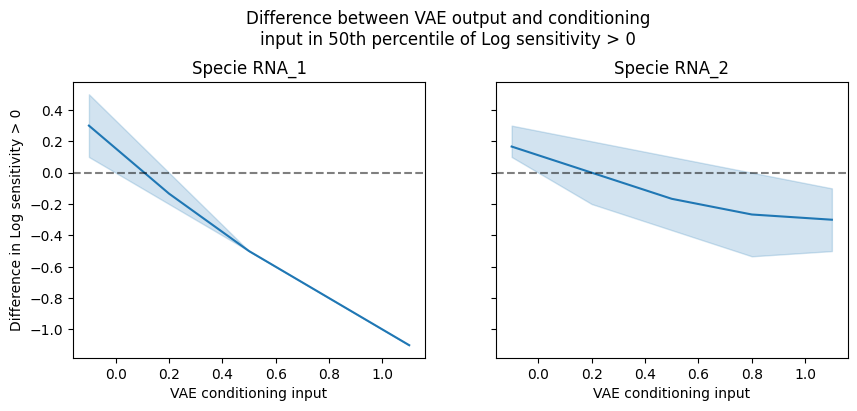

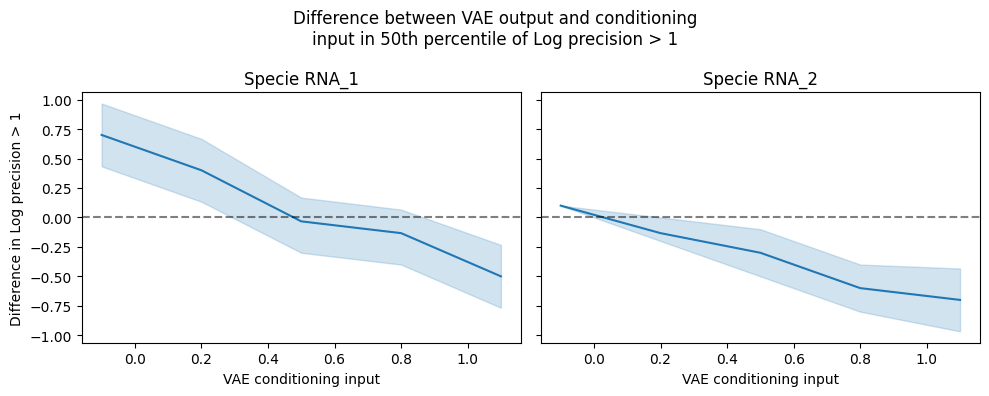

In [106]:
for ik, k in enumerate(config_dataset.objective_col):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    fig.subplots_adjust(hspace=0.3, top=0.8)
    for i, output_specie in enumerate(output_species):
        output_idx = all_species.index(output_specie)
        diffs_conditional_real_sens = jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
            analytics[k][:, output_idx].reshape(n_categories, int(hpos['eval_n_to_sample']) // n_categories)) - sampled_conds[:, ik, None]
        diff_df = pd.DataFrame(np.concatenate([sampled_conds[:, ik, None], diffs_conditional_real_sens], axis=1), columns=['index', '25th', '50th', '75th']).set_index('index')
        diff_df = diff_df.melt(var_name='Percentile', value_name='Difference', ignore_index=False).reset_index().rename(columns={'index': 'Conditioning input'})
        sns.lineplot(diff_df, x='Conditioning input', y='Difference', ax=axs[i])
        axs[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        analytic_reshaped = analytics[k][:, output_idx].reshape(n_categories, int(hpos['eval_n_to_sample']) // n_categories)
        sampled_conds_expanded = np.ones_like(analytic_reshaped) * sampled_conds[:, ik, None]
        precision, recall, f1 = calc_prompt_adherence(sampled_conds_expanded, analytic_reshaped, 0.1)

        axs[i].set_xlabel('VAE conditioning input')
        axs[i].set_ylabel(f'Difference in {k}')
        axs[i].set_title(f'Specie {output_specie}') #: recall = {np.nanmean(recall):.2f}')
        # print('Diffs:', diffs_conditional_real_sens[:, 1], np.sum(
        #     np.abs(diffs_conditional_real_sens[:, 1])))
        
    plt.suptitle(
        f'Difference between VAE output and conditioning\ninput in 50th percentile of {k}')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'diffs_sens_recall.png'), dpi=300, transparent=True)

# diff_m = np.abs(sampled_conds_expanded - analytic_reshaped).mean(axis=1)
# diff_s = np.abs(sampled_conds_expanded - analytic_reshaped).std(axis=1)
# diff_m, diff_s

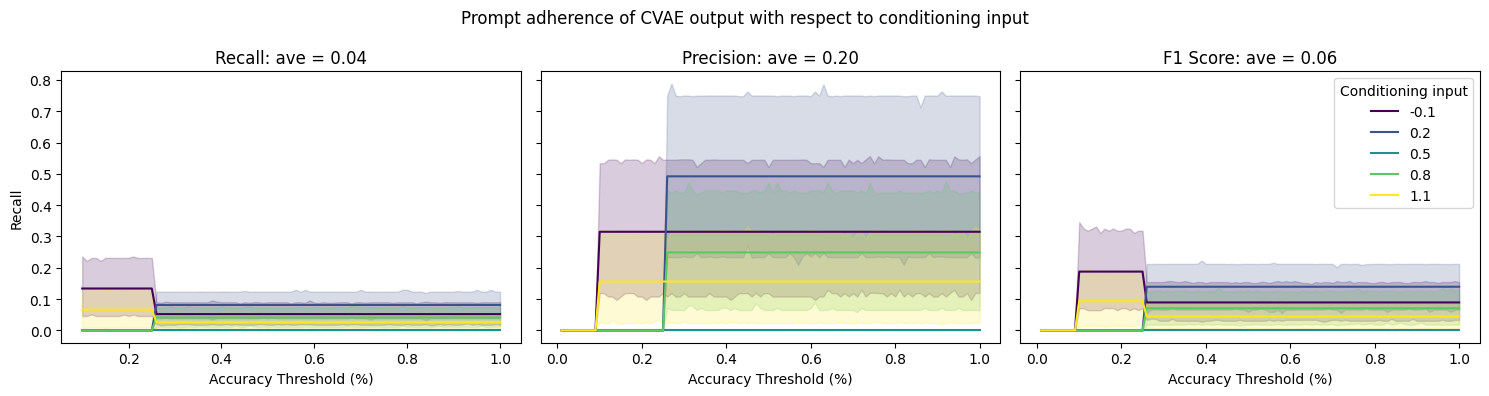

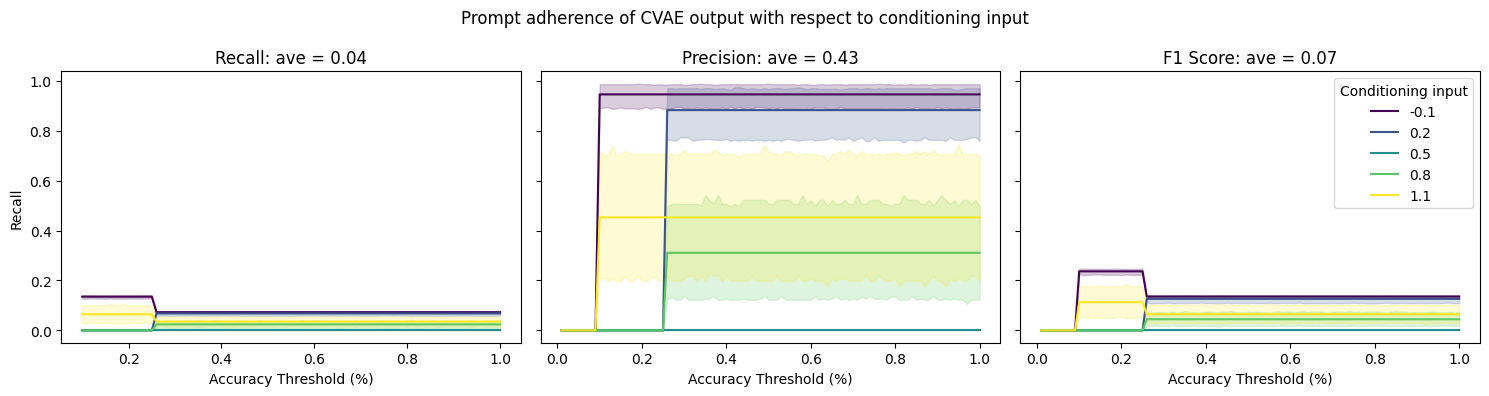

In [107]:
sampled_conds = sampled_conds.round(3)


for i, k in enumerate(config_dataset.objective_col):

    perc_recall = np.arange(0.01, 1.01, 0.01).astype(np.float32)
    analytics_reshaped = analytics[k][:, output_idx].reshape(n_categories, int(hpos['eval_n_to_sample']) // n_categories)
    sampled_conds_expanded = np.ones_like(analytic_reshaped) * sampled_conds[:, ik, None]
    precision, recall, f1 = jax.vmap(partial(calc_prompt_adherence, pred=sampled_conds_expanded, real=analytics_reshaped))(perc_recall=perc_recall)

    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(5*3, 4))
    df_recall = pd.DataFrame(data=recall.T, columns=perc_recall, index=sampled_conds[:, ik]).melt(var_name='Accuracy Threshold (%)', value_name='Recall', ignore_index=False).reset_index().rename(columns={'index': 'Conditioning input'})
    sns.lineplot(df_recall, x='Accuracy Threshold (%)', y='Recall', hue='Conditioning input', palette='viridis', ax=axs[0], legend=False)
    axs[0].set_title(f'Recall: ave = {np.nanmean(recall):.2f}')

    df_precision = pd.DataFrame(data=precision.T, columns=perc_recall, index=sampled_conds[:, ik]).melt(var_name='Accuracy Threshold (%)', value_name='Precision', ignore_index=False).reset_index().rename(columns={'index': 'Conditioning input'})
    sns.lineplot(df_precision, x='Accuracy Threshold (%)', y='Precision', hue='Conditioning input', palette='viridis', ax=axs[1], legend=False)
    axs[1].set_title(f'Precision: ave = {np.nanmean(precision):.2f}')

    df_f1 = pd.DataFrame(data=f1.T, columns=perc_recall, index=sampled_conds[:, ik]).melt(var_name='Accuracy Threshold (%)', value_name='F1', ignore_index=False).reset_index().rename(columns={'index': 'Conditioning input'})
    sns.lineplot(df_f1, x='Accuracy Threshold (%)', y='F1', hue='Conditioning input', palette='viridis', ax=axs[2])
    axs[2].set_title(f'F1 Score: ave = {np.nanmean(f1):.2f}')

    plt.suptitle('Prompt adherence of CVAE output with respect to conditioning input')
    plt.tight_layout()

    plt.savefig(os.path.join(top_write_dir, f'recall_f1_{k}.png'), dpi=300, transparent=True)



In [108]:
# for k in config_dataset.objective_col:
#     plt.figure()
#     output_idx = all_species.index(
#         config_dataset.output_species[0])
#     diffs_conditional_real_sens = jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
#         analytics[k][:, output_idx].reshape(n_categories, int(hpos['eval_n_to_sample']) // n_categories)) - sampled_conds[:, None]
#     plot_diffs(diffs_conditional_real_sens, sampled_conds, plt.subplot(1, 1, 1),
#                palette=sns.cubehelix_palette(start=3, rot=0, dark=0.6, light=.6, reverse=False, as_cmap=False, n_colors=n_categories))
#     #  palette=sns.cubehelix_palette(start=1, rot=1.5, dark=0.3, light=.7, reverse=False, as_cmap=False, n_colors=10))
#     plt.title(
#         f'Difference between target {k} and\n50th percentile of actual: Species {config_dataset.output_species[0]}')

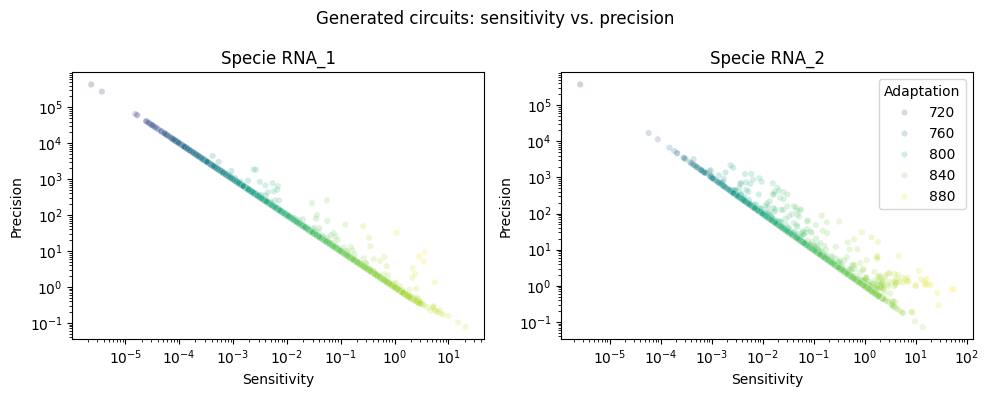

In [109]:
fig = plt.figure(figsize=(10, 4))

# category_array = np.array(sorted(y_datanormaliser.metadata[config_dataset.objective_col[0]]["category_map"].values())).repeat(
#     len(analytics['sensitivity_wrt_species-6'])//len(y_datanormaliser.metadata[config_dataset.objective_col[0]]["category_map"]))
# category_array = sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), -1)
for i, output_specie in enumerate(output_species):
    output_idx = all_species.index(output_specie)
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['Adaptation'] = analytics['adaptation'][:, output_idx]
    # d['VAE conditioning input'] = category_array
    d['VAE conditioning input'] = np.array([', '.join(map(str, row)) for row in category_array])
    ax = plt.subplot(1,2,i+1)
    sns.scatterplot(d, x='Sensitivity', y='Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20, legend=i == len(output_species)-1)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Specie {output_specie}')
plt.suptitle('Generated circuits: sensitivity vs. precision')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'scatter_sp_adapt.png'), dpi=300, transparent=True)

<Figure size 640x480 with 0 Axes>

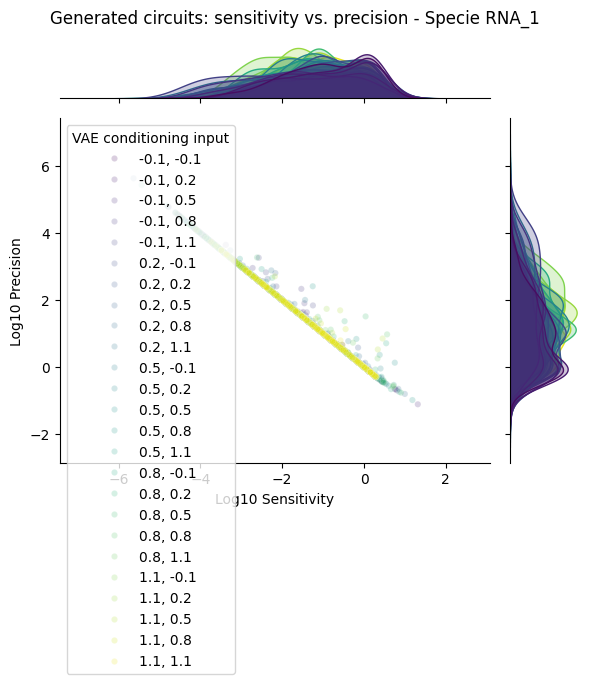

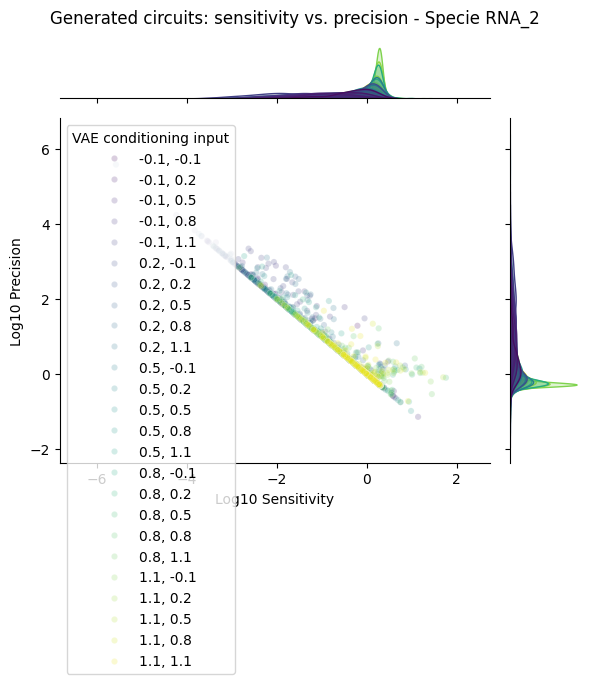

In [118]:
# fig = plt.figure(figsize=(13, 4))
plt.subplots_adjust(top=0.8)

for i, output_specie in enumerate(output_species):
    output_idx = all_species.index(output_specie)
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['Adaptation'] = analytics['adaptation'][:, output_idx]
    d['Log10 Sensitivity'] = np.log10(d['Sensitivity'])
    d['Log10 Precision'] = np.log10(d['Precision'])
    d['VAE conditioning input'] = np.array([', '.join(map(str, row)) for row in category_array.round(2)])
    # ax = plt.subplot(1,2,i+1)
    # sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20)
    sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='VAE conditioning input', palette='viridis', s=20)
    # plt.title(f'Specie {output_specie}')
    plt.suptitle(f'Generated circuits: sensitivity vs. precision - Specie {output_specie}')
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, f'joint_sp_sens_{i}.png'), dpi=300, transparent=True)

<Figure size 640x480 with 0 Axes>

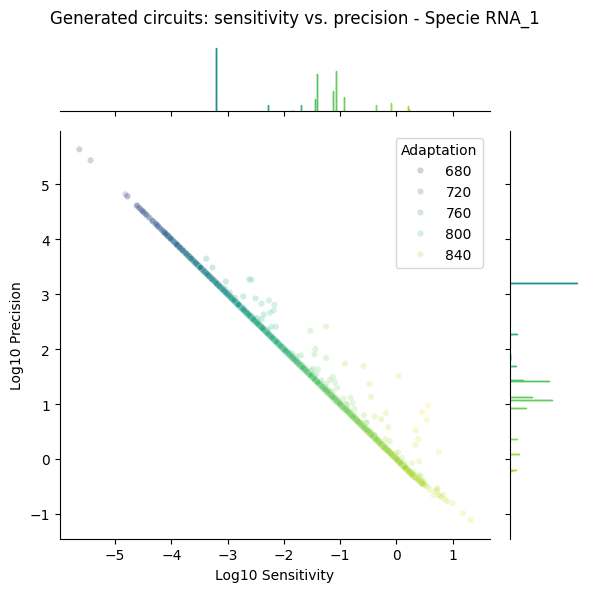

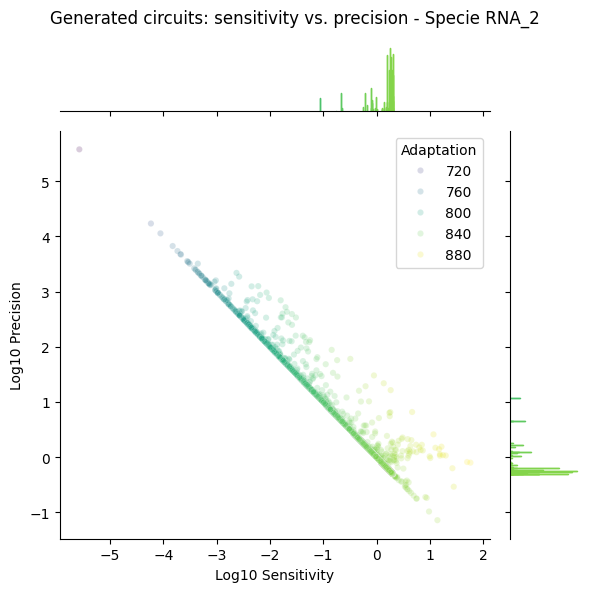

In [111]:
# fig = plt.figure(figsize=(13, 4))
plt.subplots_adjust(top=0.8)

for i, output_specie in enumerate(output_species):
    output_idx = all_species.index(output_specie)
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['Adaptation'] = analytics['adaptation'][:, output_idx]
    d['Log10 Sensitivity'] = np.log10(d['Sensitivity'])
    d['Log10 Precision'] = np.log10(d['Precision'])
    d['VAE conditioning input'] = np.array([', '.join(map(str, row)) for row in category_array.round(2)])
    # ax = plt.subplot(1,2,i+1)
    sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20)
    # plt.title(f'Specie {output_specie}')
    plt.suptitle(f'Generated circuits: sensitivity vs. precision - Specie {output_specie}')
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, f'joint_sp_adapt_{i}.png'), dpi=300, transparent=True)

# Model's best circuit

Is there a circuit generated by the model that's better than anything in the training data?

In [112]:
use_loaded = False

if use_loaded:
    # 2025_01_17__16_33_03
    # 2025_01_14__18_00_06
    # 2025_01_10__16_31_12
    analytics = load_json_as_dict(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'analytics.json'))
    fake_circuits = np.load(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'fake_circuits.npy'))
    ts = np.load(os.path.join('data/02_cvae_verify/2025_01_17__16_33_03', 'ts.npy'))
    sampled_cond = np.load(os.path.join('data/02_cvae_verify/2025_01_21__16_23_09', 'sampled_cond.npy'))
    for k in analytics.keys():
        analytics[k] = np.array(analytics[k])
    if 'Log sensitivity' not in analytics:
        analytics['Log sensitivity'] = np.log10(analytics['sensitivity_wrt_species-6'])
        analytics['Log precision'] = np.log10(analytics['precision_wrt_species-6'])
    analytics['adaptation'] = calculate_adaptation(
        analytics['sensitivity_wrt_species-6'], analytics['precision_wrt_species-6'])


In [113]:
df_analytics = pd.DataFrame({k: v.flatten() for k, v in analytics.items()})
df_analytics['sample_name'] = np.repeat(np.arange(9)[:, None], repeats=len(df_analytics)//9, axis=1).T.flatten()

In [114]:
output_idx = -1
print('Max s1\tMax s2\tMax a\tSens at max adapt')

output_training = {}
output_model = {}
for k in ['Max response time', 'Max log10 sensitivity', 'Max adaptation', 'Max sensitivity at max adaptation']:
    output_training.setdefault(k, [])
    output_model.setdefault(k, [])
for p in np.arange(0.1, 1.1, 0.01):
    filt = (np.abs(data['Log sensitivity']) < np.inf) & data['sample_name'].isin(
        ['RNA_2']) & (data['response_time_wrt_species-6'] < (p*ts.max()))
    filt2 = (df_analytics['response_time_wrt_species-6']
             < (p*ts.max())) & (df_analytics['sample_name'] == 8)
    # stats = (np.max(df_analytics[filt2]['Log sensitivity']),
    #       np.max(data[filt]['Log sensitivity']),
    #       np.max(data[filt]['adaptation']),
    #       data[filt & (data['adaptation'] == np.max(data[filt]['adaptation']))]['Log sensitivity'].iloc[0])
    # print(''.join([f'{s:.2f}\t' for s in stats]))
    
    output_training['Max response time'].append(p*ts.max())
    output_training['Max log10 sensitivity'].append(np.max(data[filt]['Log sensitivity']))
    output_training['Max adaptation'].append(np.max(data[filt]['adaptation']))
    output_training['Max sensitivity at max adaptation'].append(data[filt & (data['adaptation'] == np.max(data[filt]['adaptation']))]['Log sensitivity'].iloc[0])
    
    output_model['Max response time'].append(p*ts.max())
    output_model['Max log10 sensitivity'].append(np.max(df_analytics[filt2]['Log sensitivity']))
    output_model['Max adaptation'].append(np.max(df_analytics[filt2]['adaptation']))
    output_model['Max sensitivity at max adaptation'].append(df_analytics[filt2 & (df_analytics['adaptation'] == np.max(df_analytics[filt2]['adaptation']))]['Log sensitivity'].iloc[0])

Max s1	Max s2	Max a	Sens at max adapt


In [115]:
output_training = pd.DataFrame(output_training)
output_training['Source'] = 'Training data'
output_model = pd.DataFrame(output_model)
output_model['Source'] = 'Model generated'

df_maxes = pd.concat([output_training, output_model]).reset_index(drop=True)

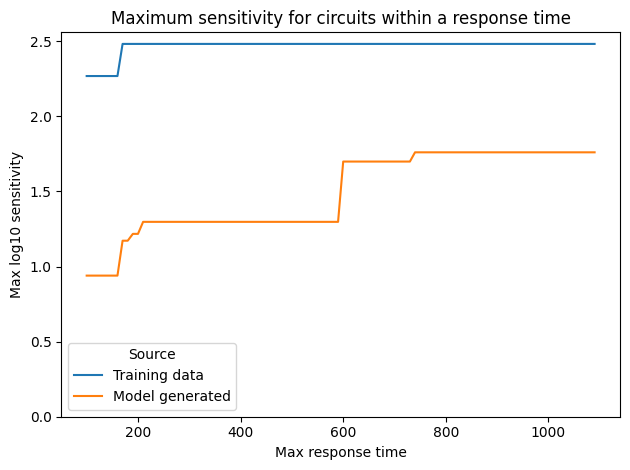

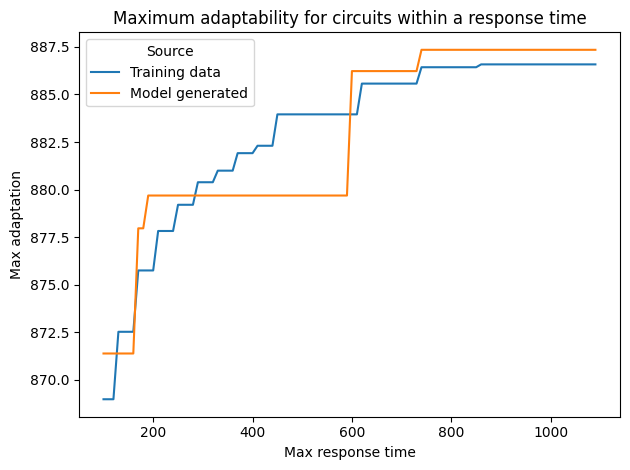

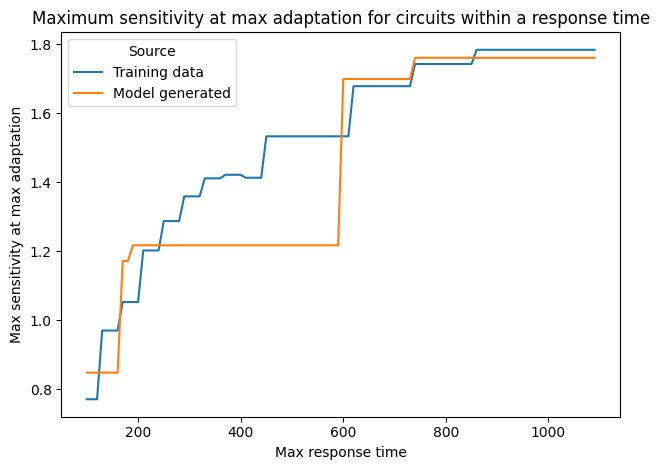

In [116]:
sns.lineplot(df_maxes, x='Max response time', y='Max log10 sensitivity', hue='Source')
plt.ylim(0, None)
plt.title('Maximum sensitivity for circuits within a response time')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'line_max_sens.png'), dpi=300, transparent=True)

plt.figure()
sns.lineplot(df_maxes, x='Max response time', y='Max adaptation', hue='Source')
plt.title('Maximum adaptability for circuits within a response time')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'line_max_adapt.png'), dpi=300, transparent=True)

plt.figure()
sns.lineplot(df_maxes, x='Max response time', y='Max sensitivity at max adaptation', hue='Source')
plt.title('Maximum sensitivity at max adaptation for circuits within a response time')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'line_max_maxadaptsens.png'), dpi=300, transparent=True)

